### Imports

In [40]:
import numpy as np
import pandas as pd
import gensim
import sys
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import pylab
from lapsolver import solve_dense
from numpy.linalg import norm
from numba import njit
from skimage import io
from sklearn.preprocessing import MinMaxScaler

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline
tqdm.pandas()

### Load in the captions DataFrame

In [41]:
df = pd.read_csv('../data/2017/captions.csv')
print(len(df))
df.head()

3242


,coco_url,height,width,id,captions
0,http://images.cocodataset.org/val2017/00000039...,427,640,0,rolling pots oven pies table standing near mad...
1,http://images.cocodataset.org/val2017/00000003...,230,352,1,decorated ready small kitchen near clean see w...
2,http://images.cocodataset.org/val2017/00000025...,428,640,2,past city walking dwellers walk standing next ...
3,http://images.cocodataset.org/val2017/00000008...,480,640,3,skateboard tricks falls bike air performs skat...
4,http://images.cocodataset.org/val2017/00000017...,388,640,4,fixture walk blue sidewalk locked next side ne...


### Load in the Word2Vec model

In [42]:
limit = 100000
model = gensim.models.KeyedVectors.load_word2vec_format('../data/wiki.vec',
                                                       binary=False,
                                                       limit=limit)
model.init_sims(replace=True)

### Gensim's built in method is too slow... (Predicted 30 hours to finish!)

In [50]:
# d = np.zeros(shape=(len(df), len(df)))
# for i in tqdm(range(len(df))):
#     for j in range(i+1, len(df)):
#         s1, s2 = [df['captions'].iloc[k].split(' ') for k in [i, j]]
#         d = model.wmdistance(s1, s2)

KeyboardInterrupt: 

### Map the captions to indices of an array of Word2Vec vectors

In [70]:
vec_arr = []
word_dict = {}
def caption_to_vec(text):
    vec = []
    for word in text.split():
        if word not in model:
            continue
        if word not in word_dict:
            idx = len(word_dict.keys())
            word_dict[word] = idx
            vec_arr.append(model[word])
        vec.append(word_dict[word])
    return np.array(vec, dtype=np.int)

df['captions_vec'] = df['captions'].progress_apply(lambda text: caption_to_vec(text))
vec_arr = np.array(vec_arr)
print(f'There are {vec_arr.shape[0]} unique words')


There are 5070 unique words


In [71]:
df.head()

,coco_url,height,width,id,captions,captions_vec
0,http://images.cocodataset.org/val2017/00000039...,427,640,0,rolling pots oven pies table standing near mad...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,http://images.cocodataset.org/val2017/00000003...,230,352,1,decorated ready small kitchen near clean see w...,"[22, 23, 24, 15, 6, 25, 26, 27, 28, 29, 30, 4,..."
2,http://images.cocodataset.org/val2017/00000025...,428,640,2,past city walking dwellers walk standing next ...,"[35, 36, 37, 38, 39, 5, 40, 41, 42, 43, 44, 45..."
3,http://images.cocodataset.org/val2017/00000008...,480,640,3,skateboard tricks falls bike air performs skat...,"[51, 52, 53, 54, 55, 56, 57, 58, 18, 10, 59, 6..."
4,http://images.cocodataset.org/val2017/00000017...,388,640,4,fixture walk blue sidewalk locked next side ne...,"[65, 39, 66, 67, 68, 40, 69, 6, 54, 70, 36, 71..."


### If we want we can apply a simple transformation to the distances

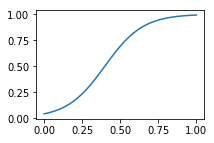

In [58]:
@njit
def sigmoid(x):
    return 1 / (1 + np.exp(-8*(x - 0.4)))

x = np.linspace(0, 1, 50)
y = sigmoid(x)
plt.figure(figsize=(3,2))
plt.plot(x, y)

### Precompute the cosine similarity between each pair of words

In [85]:
@njit
def create_pair_to_dist(vec_arr):
    W = vec_arr.shape[0]
    pair_to_dist = np.zeros(shape=(W, W), dtype=np.float32)
    for i in range(W):
        for j in range(i+1, W):
            u, v = vec_arr[i], vec_arr[j]
            # d = sigmoid(np.dot(u, v)/(norm(u)*norm(v)))
            d = np.dot(u, v)/(norm(u)*norm(v))
            pair_to_dist[i][j] = d
            pair_to_dist[j][i] = d
    return pair_to_dist

pair_to_dist = create_pair_to_dist(vec_arr)

### Calculate the earthmover distance between each pair of captions

In [86]:
@njit(fastmath=True)
def calculate_dist_matrix(u, v, d):
    mat = np.zeros(shape=(u.shape[0], v.shape[0]), dtype=np.float32)
    for i in range(u.shape[0]):
        for j in range(v.shape[0]):
            mat[i][j] = d[u[i]][v[j]]
    return mat


@njit(fastmath=True)
def numba_mean(arr):
    total = 0
    for a in arr:
        total += a
    return total/arr.shape[0]


def earthmover(u, v):
    dist_matrix = calculate_dist_matrix(u, v, pair_to_dist)
    assignment = solve_dense(dist_matrix)
    score = numba_mean(dist_matrix[assignment])
    return score


def create_ids_to_dist(captions_vecs):
    N = len(captions_vecs)
    ids_to_dist = np.zeros(shape=(N, N), dtype=np.float16) 
    for i in tqdm(range(N)):
        for j in range(i+1, N):
            u, v = captions_vecs[i], captions_vecs[j]
            dist = earthmover(u, v)
            ids_to_dist[i][j] = dist
            ids_to_dist[j][i] = dist
    return ids_to_dist

captions_vecs = list(df['captions_vec'])
ids_to_dist = create_ids_to_dist(captions_vecs)

### Turn all distances into scores in the range 0-100

In [87]:
scaler = MinMaxScaler(feature_range=(0, 100))
ids_to_score = scaler.fit_transform(-ids_to_dist)
print(ids_to_score[:5])

c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[[100.     35.38   30.62  ...  17.19   15.875  31.25 ]
 [ 32.3   100.     11.44  ...  15.94   19.12   20.94 ]
 [ 29.5    14.125 100.    ...  14.06   12.375  23.88 ]
 [ 33.     20.5    29.19  ...  11.81   16.94   22.31 ]
 [ 18.69   15.56   40.1   ...  10.125  13.     13.375]]


### Save the ids_to_score array

In [91]:
arr_size = sys.getsizeof(ids_to_score) / (1024**2)
print(f'ids_to_score is of size {arr_size:.2f} MB')

ids_to_score is of size 20.05 MB


In [92]:
np.save('ids_to_score.npy', ids_to_score)

In [2]:
ids_to_score = np.load('ids_to_score.npy')

### Find the closest picture to the given id

Best score: 65
****************************************************************************************************
traffic city different night many christmas next stop big lights covered red bright time empty street background terrain tree rain light lots
****************************************************************************************************
traffic stoplights head red road stop intersection blurry oncoming night shining light lights street time cars
****************************************************************************************************


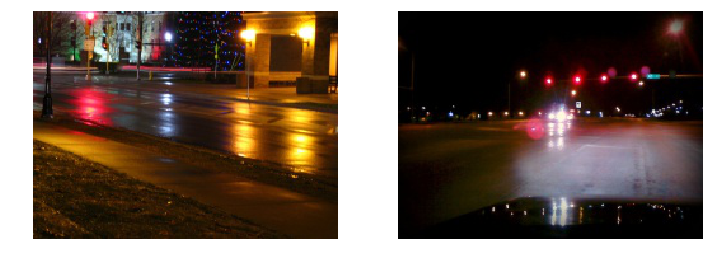

In [39]:
def calculate_closest_id(idx):
    possible_ids = list(range(ids_to_score.shape[0]))
    possible_ids.remove(idx)
    scores = np.array([(i, ids_to_score[idx][i]) for i in possible_ids])
    
    closest_id, best_score = max(scores, key=lambda x: x[1])
    print(f'Best score: {int(best_score)}')
    print('*'*100)
    return int(closest_id)

random_id = np.random.choice(df['id'])
closest_id = calculate_closest_id(random_id)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, idx in enumerate([random_id, closest_id]):
    path = f'../../static/pictures/{idx}.jpg'
    img = io.imread(path)
    caption = df['captions'].iloc[idx]
    print(caption)
    print('*'*100)
    ax[i].imshow(img)
    ax[i].axis('off')

In [21]:
lengths = [len(i.split(' ')) for i in df['captions']]
counts = np.bincount(lengths)
print(counts)

[  0   0   0   0   0   0   0   3   4   9  16  44  92 131 203 267 308 307
 338 360 293 212 198 172  91  73  47  29  14  15   6   3   4   1   1   0
   0   0   0   1]


<BarContainer object of 40 artists>

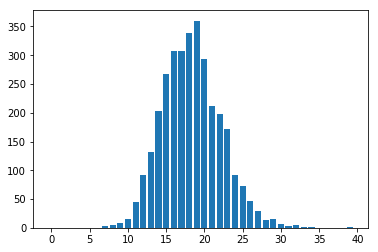

In [18]:
plt.bar(list(range(counts.shape[0])), counts)